# Lab 4: Fine-mapping with SuSiE

SuSiE is a state-of-art fine-mapping method based on Bayesian variable selection regression. The name of "**SuSiE**" means the **Su**m of **Si**ngle **E**ffects, which detects single causal effect one at a time but also extends to multiple effects through conditional analysis. 

SusieR package was developed to run fine-mapping procedures over GWAS summary statistics or individual level genotype/phenotype data. More details about the SusieR package can be found at [SusieR github page] [https://stephenslab.github.io/susieR/index.html].

By the end of the lab, you should be able to:

- **Understand the types of input files for running susieR**
- **Interpret output results from susieR**
- **Evaluate the effects of setting different numbers of causal variants on the results**
- **Compare the effects of using different LD reference panels on the results**

## Load packages and data

In [ ]:
library(susieR)
library(data.table)
library(dplyr)
library(bigsnpr)
library(ggplot2)
load("susie.RData")

## Dataset
* GWAS summary statistics (after QC):
    - Body mass index as the phenotype
    - A meta-analysis of Locke et al. 2015 and analyses from UK Biobank
    - No individual genotypes are provided
    - Chr, pos, rsID, effect/non-effect alleles, beta, se, p-values, odds ratio, N, etc.

* Reference LD panels from 1000 genome or UK Biobank
    - chr, pos, rsID, major/minor alleles, etc.
    - LD matrix: pair-wise LD coefficients across each LD block
  
* LD blocks:
    - Based on the European haplotypes, researchers have built 1704 LD blocks, where variants across blocks are not correlated.

  
## Input files for susieR

* Individual level phenotypes/genotypes: `susie()` or Summary statistics: `susie_rss()`
* LD coefficients (R)
* Expected number of causal variants (L)
  

# Run susieR on the simulated example 
Let's first test the performance of susieR on the simulated dataset. We load the N3finemapping data from susieR package:

In [5]:
data(N3finemapping)
attach(N3finemapping)
str(N3finemapping)

List of 8
 $ X                : num [1:574, 1:1001] -0.0209 -0.0209 -0.0209 -0.0209 -0.0209 ...
 $ chrom            : chr "chr19"
 $ pos              : int [1:1001(1d)] 8126133 8126300 8126517 8126687 8126945 8127002 8127406 8127486 8127541 8127775 ...
 $ true_coef        : num [1:1001, 1:2] 0 0 0 0 0 0 0 0 0 0 ...
 $ residual_variance: num [1:2(1d)] 6.29 1.65
 $ Y                : num [1:574, 1:2] 0.2284 -0.6509 0.0768 -3.1507 2.338 ...
 $ allele_freq      : num [1:1001, 1] 0.0105 0.2631 0.419 0.0261 0.0819 ...
 $ V                : num [1:2, 1:2] 7.842 -0.221 -0.221 2.131


We can identify which variables are simulated as truly causal by searching for $b\neq0$.

[1] 403 653 773

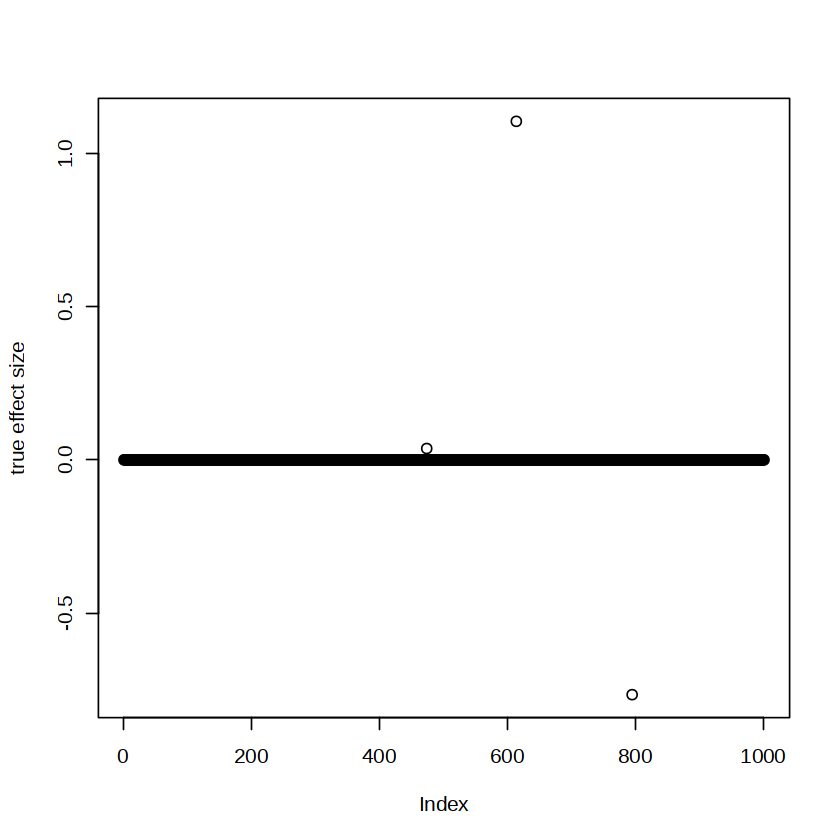

In [6]:
which(true_coef[,1] != 0)
plot(true_coef[,2], ylab = "true effect size")

Run linear regression to obtain p-values, similar to running GWAS.

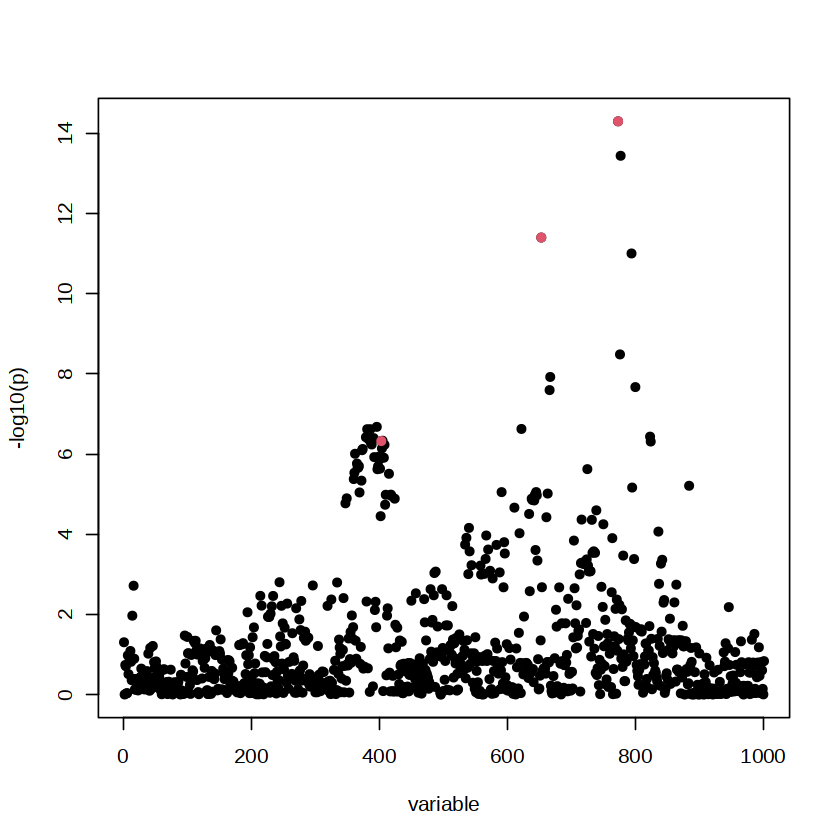

In [10]:
sumstats <- univariate_regression(X, Y[,1])
z_scores <- sumstats$betahat / sumstats$sebetahat
susie_plot(z_scores, y = "z", b = true_coef[,1])

## Fine-mapping with susieR at L = 1

The susie_plot() function is a scatter plot of PIP or z scores against variant index. The variables selected into credible sets are colored by groups.

In [ ]:
fitted.L1 <- susie(X, Y[,1], L = 1)
susie_plot(fitted.L1, y = "PIP")

## Fine-mapping with susieR at L = 10

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



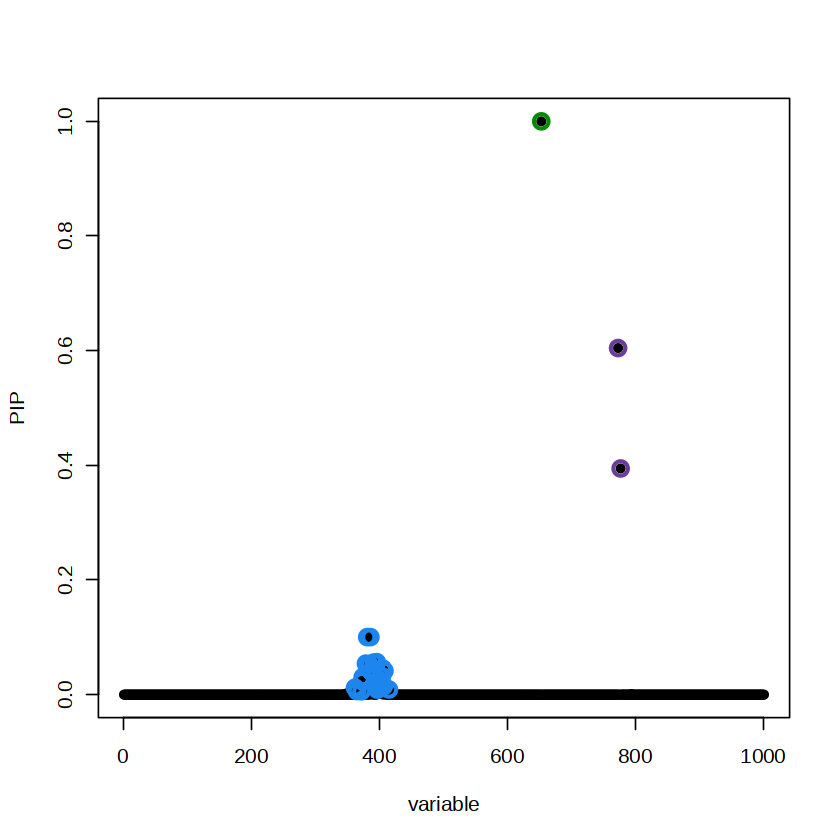

In [7]:

fitted.L10 <- susie(X, Y[,1], L = 10)
susie_plot(fitted.L10, y = "PIP")

By default, a credible set is defined as the minimum set of variables of which PIPs sum up to be at least 95%, and the minimum mean correlations within a set to be 0.5.

**Problem 1** 
With seting L = 10, are the causal variables included in the credible sets?

In [8]:
print(fitted.L10$sets)

$cs
$cs$L2
[1] 653

$cs$L1
[1] 773 777

$cs$L3
 [1] 362 365 372 373 374 379 381 383 384 386 387 388 389 391 392 396 397 398 399
[20] 400 401 403 404 405 407 408 415


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L2    1.0000000     1.0000000       1.0000000
L1    0.9815726     0.9815726       0.9815726
L3    0.8686309     0.9640176       0.9720711

$cs_index
[1] 2 1 3

$coverage
[1] 0.9998236 0.9988858 0.9539811

$requested_coverage
[1] 0.95



There isn't a uniquely optimal strategy of choosing L. In practice, I often try both L = 5 and L = 10 and check the credible set distribution at individual loci.

# Fine-mapping on GWAS summary statistics
Let's first take a look at GWAS summary statistics file. There is one additional column that specifies the LD block that each variant belongs to.

In [ ]:
head(gwas)
gwas <- split(gwas, gwas$block)
names(gwas)

By plotting -log10(p) against genomic positions, we see many SNPs near the lead SNP passing the significance threshold. To help prioritize SNPs for downstream analysis and validation, fine-mapping provides a statistical approach to evaluate each SNP's causal probability.

In [ ]:
orig.gwas <- gwas[["1452"]]
plot(x = orig.gwas$pos, y = -log10(orig.gwas$pval), 
     xlab = "pos", ylab="-log10(p)")

## Step 1: Match variants between GWAS summary stats and LD panel
Bigsnpr is a very useful R packpage to process genotype data. We will use its "snp_match" function to match variants in GWAS summary stats and LD panels. This function outputs a summary table with GWAS summary statistics for the matched SNPs and additional columns such as the "bigSNP_index", the index number for each matched variant in the LD panels. We will further utilize these index numbers to quickly extract the LD coefficients from the LD matrix.

In [ ]:
matched.gwas <- as_tibble(bigsnpr::snp_match(sumstats = gwas[["1452"]], 
                          info_snp = bigSNP[["1452"]]$map) %>% 
                          dplyr::rename(og_index = `_NUM_ID_.ss`) %>% 
                          dplyr::rename(bigSNP_index = `_NUM_ID_`))

**Problem 2**
From the help page of "snp_match" function, we know when the alleles are reversed the directions of beta values will be reversed as well. Let's make a scatter plot comparing the beta values from original gwas against those from the matched GWAS. 

**Problem 3**
Make the same plot for z-scores. The directions of z scores can have a big impact on susie's performance. So be careful about specifying the right z-scores used in susie. Otherwise, you can directly compute z-scores (dividing beta by se). This relationship also implies the direction of z scores should be the same as beta. 

Knowing the directions of z scores were not updated, we manually computed the z scores in the following codes and repeated this step by looping over all the LD blocks.

In [ ]:
for(i in names(gwas)){
  gwas[[i]] <- as_tibble(bigsnpr::snp_match(sumstats = gwas[[i]], 
                          info_snp = bigSNP[[i]]$map) %>%  
                          dplyr::rename(og_index = `_NUM_ID_.ss`) %>% 
                          dplyr::rename(bigSNP_index = `_NUM_ID_`)) %>%
                          dplyr::mutate(z_matched = beta/se)
}

## Step 2: Extract LD coefficients for the tested SNPs

The given LD matrix for each LD block is a N by N matrix, where N is the number of common variants within the block. The row and column index match with the "bigSNP_index" in the summary table output from snp_match function.

In [ ]:
snps.vec <- gwas[["1452"]]$bigSNP_index
r2.mat <- bigSNP[["1452"]]$LD_matrix[snps.vec, snps.vec]
dim(r2.mat)
# check if the bigSNP_index matches between GWAS and the LD panel
sum(gwas[["1452"]]$snp != bigSNP[["1452"]]$map[snps.vec, "id"])

## Step 3: run susie_rss() for summary statistics

Let's first try L = 1. Here we sepcified z scores as the column of "z_matched", which was corrected by directions.

In [ ]:
res.L1 <- susieR::susie_rss(z = gwas[["1452"]]$z_matched, R = r2.mat, L = 1)
summary(res.L1)
res.L1[["z"]] <- gwas[["1452"]]$z_matched
# Run the following three lines of code together
par(mfrow = c(1,2))
susie_plot(res.L1, "PIP", add_legend = "topleft")
susie_plot(res.L1, y = "z")

From the output summary, we know one credible set was identified. There are two variants, index 482 and 492, included in the credible set, each with around 0.5 posterior probability. As their average LD correlation is very close to one, SuSiE was not able to distinguish between them. Therefore, the probability of being causal given data were equally distributed between these two variables. 

**Problem 4**
Run susie at L = 10 and then report the number of variables selected in each credible set. Additionally, use susie_plot() to visualize the distributions of PIPs and -log10(pval).

Now we are done with the general procedures for running susie. Let's put them together and loop over all the blocks.

In [ ]:
susie.ukb.L10 <- list()
for(i in names(gwas)){
  snps.vec <- gwas[[i]]$bigSNP_index
  r2.mat <- bigSNP[[i]]$LD_matrix[snps.vec, snps.vec]
  susie.ukb.L10[[i]] <- susie_rss(z = gwas[[i]]$z_matched, R = r2.mat, L = 10)
  susie.ukb.L10[[i]][["z"]] <- gwas[[i]]$z_matched  # add the original z-scores to SuSiE outputs
}

# Compare different LD panels
Lastly, we will examine how the mismatch of LD matrix can affect how variants are selected into credible sets . Our previous analysis was based on the LD matrix computed over around 50K British individuals provided by UK Biobank. In the dataset, we also provided the fine-mapped results using the LD matrix from samples in 1000 genome consortium. The LD matrix for the 1kg LD reference panel was computed over 500 Eurpean individuals. 

When comparing the fine-mapped results over all 97 blocks that contain GWAS lead loci, we found using 1kg LD reference panel tends to capture many more variants with non-significant p-values in credible sets. This looks suspicious and deserves some examinations. Let's focus on one specific LD block 704 and see how the results differ due to the use of different LD reference panels. 

**Problem 5**
Compare the credible sets obtained from running SuSiE using ukbb LD matrix and 1kg LD matrix. The SuSiE outputs from using 1kg LD matrix are stored in a variable called `susie.1kg.L10`. Also make the plots of PIPs or -log10(p-val) to show the difference. 

**Check the LD patterns relative to the confident SNP in credible sets**

We can also visualize LD patterns by coloring the data points by the LD coefficients relative to the SNP of interest. Particularly, we examined the SNP with the highest SNP in the additional credible set identified by SuSiE using 1kg LD reference panel. From the plot below, LD coefficients relative to the top snp rs12204742 in that credible set overall look stronger in UKB LD panel shown by darker color. When we add up the PIPs for all SNPs in the credible set identified by 1kg LD reference, the total PIP does not pass the default threshold. Thus, the fine-mapped results can be affected by the differences in LD reference panels. This differences may be sutble in this example, but more spurious results have been seen with mismatched LD references.

In [ ]:
ggplot(susie.1kg[["704"]]$gwas, aes(x=pos,y=-log10(pval), color=susie.1kg[["704"]]$LD.coef[789,])) + 
  geom_point() + 
  scale_color_gradient(low = alpha("yellow", 0.2), high ="red") + 
  labs(color = "LD coefficient", 
       title = "1kg", 
       xlab = "variable", 
       ylab = "-log10(p-val)")

ggplot(gwas[["704"]], aes(x=pos,y=-log10(pval), color=bigSNP[["704"]]$LD_matrix[gwas[["704"]][788,]$bigSNP_index, gwas[["704"]]$bigSNP_index])) + 
  geom_point() + 
  scale_color_gradient(low = alpha("yellow", 0.2), high ="red") + 
       labs(color = "LD coefficient", 
            title = "UKB", 
            xlab =  "variable", 
            ylab = "-log10(p-val)")

# PLINK association testing review

**Problem 6**
In problem 8 of Lab 3, you are asked to draw a Manhattan plot for the initial GWAS (done in problem 6) using the appropriate Bonferroni-corrected significance threshold. To correctly calculate the significance threshold, you need to first filter all the SNPs with NA p-value. However, if you look at the association statistics, there are some SNPs with a valid p-value but NA odds ratio (OR). Do we need to count these SNPs when calculating significance threshold? Why? (Hint: check the allele frequency in samples)